In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import datetime
from scipy.stats import boxcox
import statsmodels.api as sm
from statsmodels.formula.api import ols
import warnings
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, accuracy_score, precision_score, recall_score



# Ignore a specific warning
warnings.filterwarnings("ignore")

In [ ]:
circuits = pd.read_csv('circuits.csv')
drivers =  pd.read_csv('drivers.csv')
driver_standings =  pd.read_csv('driver_standings.csv')
results = pd.read_csv('results.csv')
status = pd.read_csv('status.csv')
races = pd.read_csv('races.csv')


## REMOVE COLUMNS WE WON'T BE NEEDING FROM DIFFERENT TABLES

In [ ]:
# we need to remove time and position from results table and keep positionOrder
circuits.drop(['url'],axis=1,inplace=True)
print('circuits: ', circuits.columns)
drivers.drop(['number','url'],axis=1,inplace=True)
print('drivers: ', drivers.columns)
driver_standings.drop(['positionText'],axis=1,inplace=True)
print('driver_standings: ', driver_standings.columns)
results.drop(['constructorId', 'number', 'positionText', 'position', 'time', 'milliseconds', 'fastestLap', 'rank', 'fastestLapTime','fastestLapSpeed'],axis=1,inplace=True)
print('results: ', results.columns)
races.drop(['url','fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date', 'fp3_time','quali_date', 'quali_time', 'sprint_date', 'sprint_time'],axis=1,inplace=True)
print('races: ', races.columns)


circuits:  Index(['circuitId', 'circuitRef', 'name', 'location', 'country', 'lat', 'lng',
       'alt'],
      dtype='object')
drivers:  Index(['driverId', 'driverRef', 'code', 'forename', 'surname', 'dob',
       'nationality'],
      dtype='object')
driver_standings:  Index(['driverStandingsId', 'raceId', 'driverId', 'points', 'position',
       'wins'],
      dtype='object')
results:  Index(['resultId', 'raceId', 'driverId', 'grid', 'positionOrder', 'points',
       'laps', 'statusId'],
      dtype='object')
races:  Index(['raceId', 'year', 'round', 'circuitId', 'name', 'date', 'time'], dtype='object')


In [ ]:
valid_raceids = []
for i in range(len(races)):
  if races['year'][i] > 2009:
    valid_raceids.append(races['raceId'][i])

results['grid'] = results['grid'].replace([0], 1)

## Checking for null values and duplicates in table driver_standings
## Checking for outliers in table driver_standings
## Checking for skewness in table driver_standings

In [ ]:
valid_driver_standings = []
for r_id in driver_standings['raceId']:
  if r_id in valid_raceids:
    valid_driver_standings.append(1)
  else:
    valid_driver_standings.append(0)
driver_standings['valid_driver_standings'] = valid_driver_standings

driver_standings = driver_standings[driver_standings['valid_driver_standings']>0]
driver_standings = driver_standings[driver_standings['wins']>0]

In [ ]:
duplicate = driver_standings[driver_standings.duplicated()]
print('Number of Duplicate Rows :', len(duplicate))


Number of Duplicate Rows : 0


In [ ]:
driver_standings.isna().sum()

driverStandingsId         0
raceId                    0
driverId                  0
points                    0
position                  0
wins                      0
valid_driver_standings    0
dtype: int64

points 220.0 96.0
5
position 4.0 1.0
39
wins 4.0 1.0
61


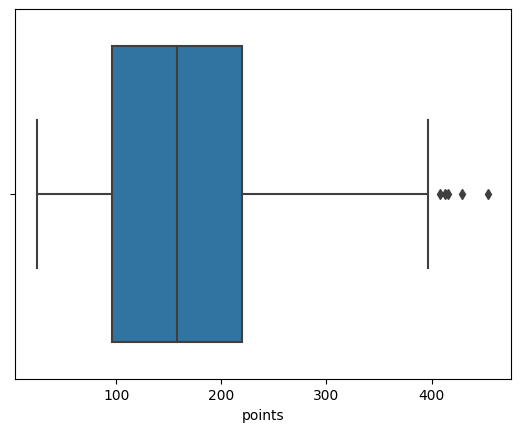

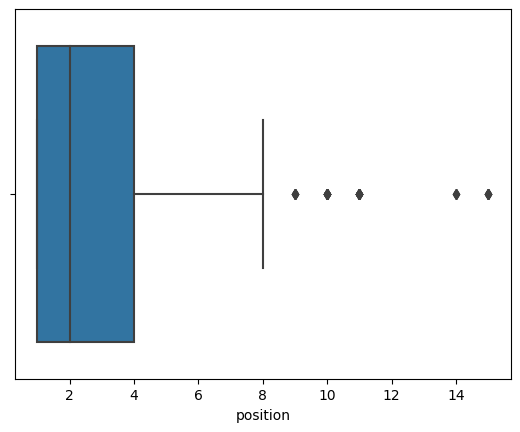

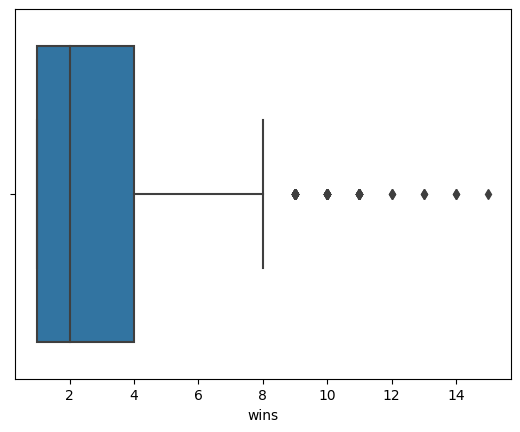

In [ ]:
df= driver_standings
cols_to_check = ['points', 'position', 'wins']
for col in df:
  if col in cols_to_check:
    plt.figure()
    sns.boxplot(x=col, data=df)
    q75,q25 = np.percentile(df[col],[75,25])

    intr_qr = q75-q25
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
    print(col, q75,q25 )

    l = []
    c = 0
    for x in df[col]:
      if x >= max:
        c += 1
        l.append(np.percentile(df[col], 99))
      elif x <= min:
        c += 1
        l.append(np.percentile(df[col], 1))
      else:
        l.append(x)
    print(c)

    df[col] = l


## Skewness after Quantile flooring

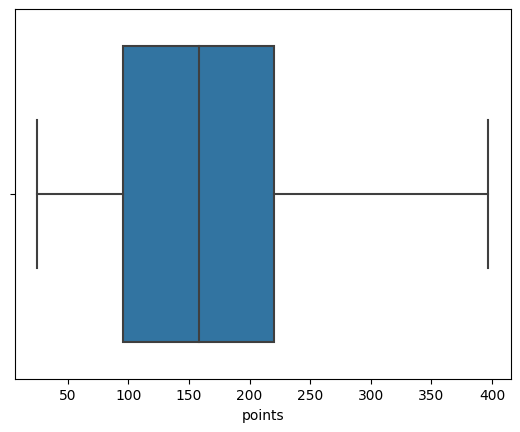

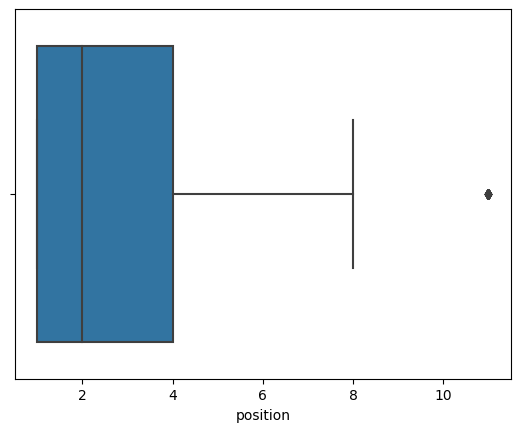

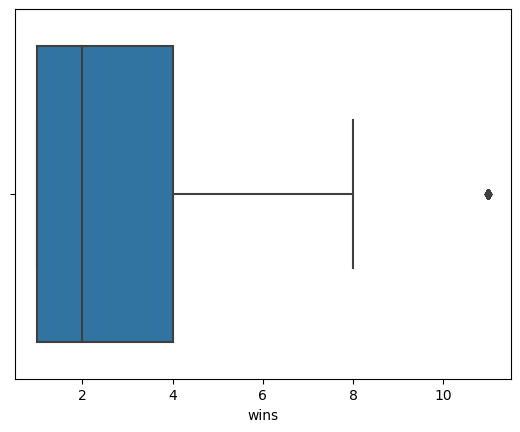

In [ ]:
for col in df:
  if col in cols_to_check:
    plt.figure()
    sns.boxplot(x=col, data=df)


points  with skewness of 0.5114135295213675
position  with skewness of 1.6784919228996635
wins  with skewness of 1.8478056353972254


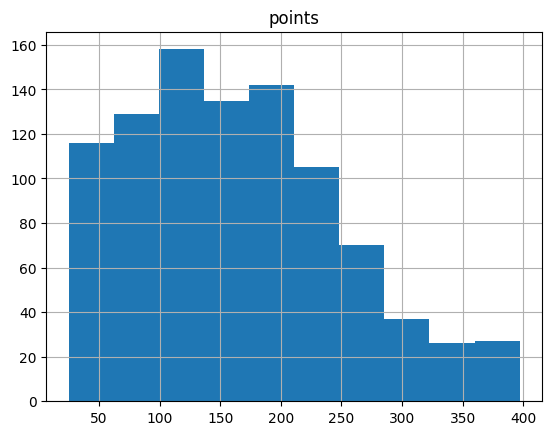

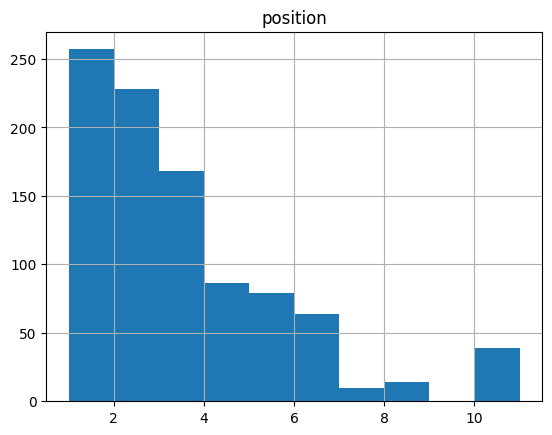

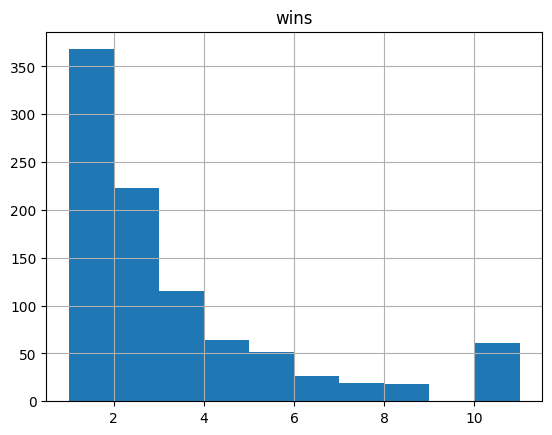

In [ ]:
df= driver_standings
cols_to_check = ['points', 'position', 'wins']
for col in df:
  if col in cols_to_check:
    print(col,' with skewness of',df[col].skew())

df.hist(column='points')
plt.show()
df.hist(column='position')
plt.show()
df.hist(column='wins')
plt.show()


## Using Boxcox transformation on columns with skewness > 0.5 or skewness < -0.5

In [ ]:
df= driver_standings
cols_to_check = ['points', 'position', 'wins']
for col in df:
  if col in cols_to_check:
    if df[col].skew() > 0.5 or df[col].skew() < -0.5:
        df[col],lmbda = boxcox(df[col],lmbda=None )

for col in df:
  if col in cols_to_check:
    print(col,' with skewness of',df[col].skew())


points  with skewness of -0.07273589690362403
position  with skewness of 0.037066464583440796
wins  with skewness of 0.17437839487501083


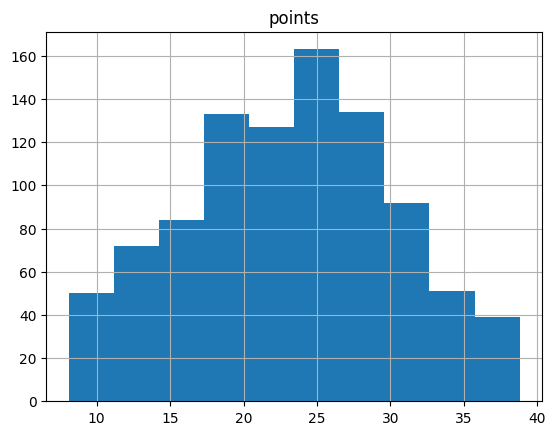

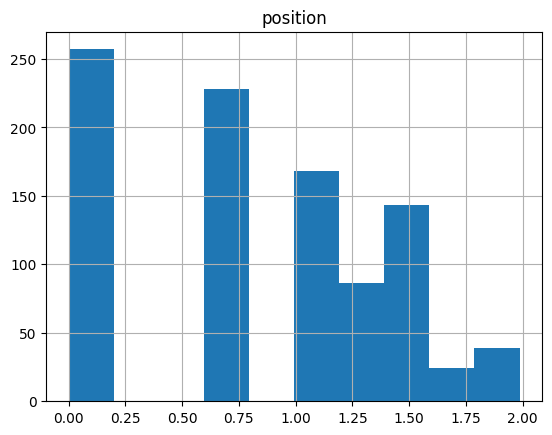

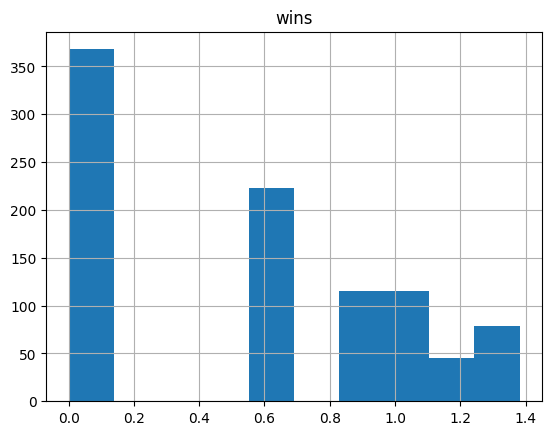

In [ ]:
df.hist(column='points')
plt.show()
df.hist(column='position')
plt.show()
df.hist(column='wins')
plt.show()


In [ ]:
print(len(driver_standings))
driver_standings  = df
print(len(driver_standings))


945
945


## Checking for null values and duplicates in table races
## Checking for outliers in table races
## Checking for skewness in table races

In [ ]:
races.isna().sum()

raceId       0
year         0
round        0
circuitId    0
name         0
date         0
time         0
dtype: int64

In [ ]:
races = races[races['year']>2009]

In [ ]:
duplicate = races[races.duplicated()]
print('Number of Duplicate Rows :', len(duplicate))


Number of Duplicate Rows : 0


year 2030.5 2002.5
0
round 31.0 -9.0
0


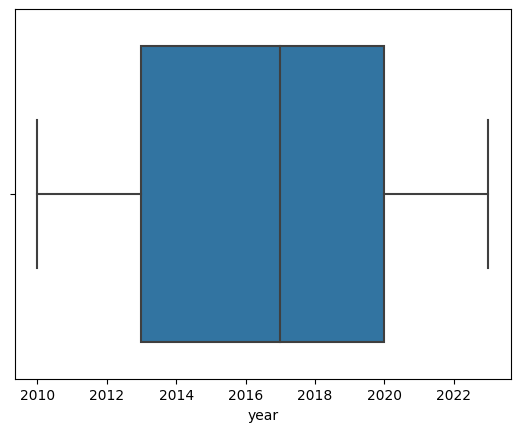

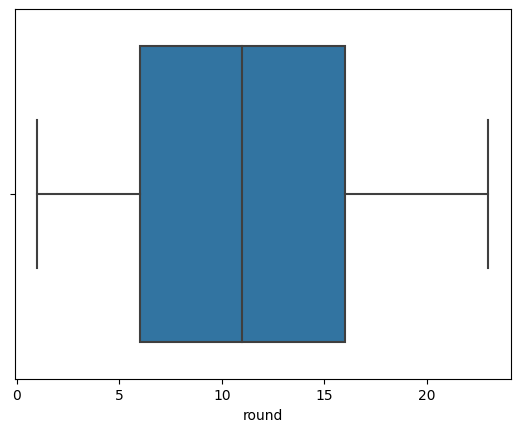

In [ ]:
df= races
cols_to_check = ['year', 'round']
for col in df:
  if col in cols_to_check:
    plt.figure()
    sns.boxplot(x=col, data=df)
    q75,q25 = np.percentile(df[col],[75,25])

    intr_qr = q75-q25
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)

    print(col, max,min )

    l = []
    c = 0
    for x in df[col]:
      if x >= max:
        c += 1
        l.append(np.percentile(df[col], 99))
      elif x <= min:
        c += 1
        l.append(np.percentile(df[col], 1))
      else:
        l.append(x)
    print(c)
    df[col] = l



## No need to remove outliers or normalise the data.

year  with skewness of -0.044790268250804524
round  with skewness of 0.058783446462841143


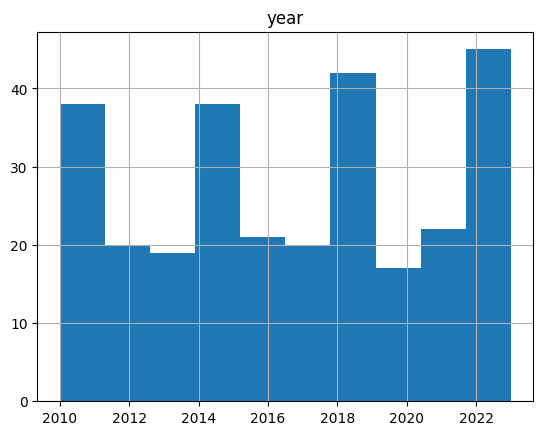

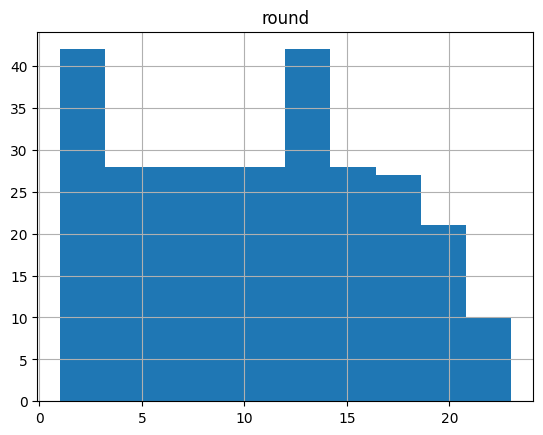

In [ ]:
df= races
cols_to_check = ['year', 'round']
for col in df:
  if col in cols_to_check:
    print(col,' with skewness of',df[col].skew())

df.hist(column = 'year')
plt.show()
df.hist(column = 'round')
plt.show()



In [ ]:
print(len(races))
races  = df
print(len(races))


282
282


## Checking for null values and duplicates in table results
## Checking for outliers in table results
## Checking for skewness in table results

In [ ]:
valid_driver_standings = []
for r_id in results['raceId']:
  if r_id in valid_raceids:
    valid_driver_standings.append(1)
  else:
    valid_driver_standings.append(0)
results['valid_driver_standings'] = valid_driver_standings

results = results[results['valid_driver_standings']>0]
results = results[results['points']>0]

In [ ]:
duplicate = results[results.duplicated()]
print('Number of Duplicate Rows :', len(duplicate))


Number of Duplicate Rows : 0


In [ ]:
results.isna().sum()

resultId                  0
raceId                    0
driverId                  0
grid                      0
positionOrder             0
points                    0
laps                      0
statusId                  0
valid_driver_standings    0
dtype: int64

grid 20.5 -7.5
28
positionOrder 15.5 -4.5
0
points 31.5 -12.5
2
laps 93.0 29.0
20


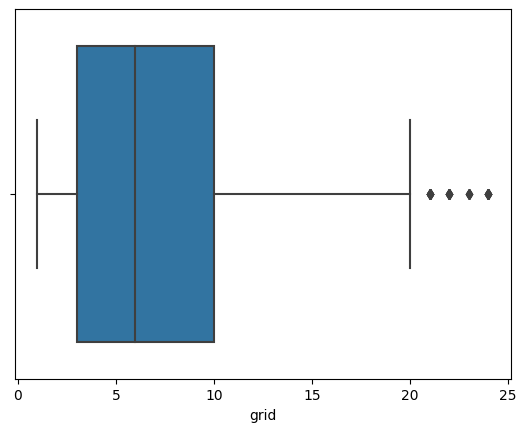

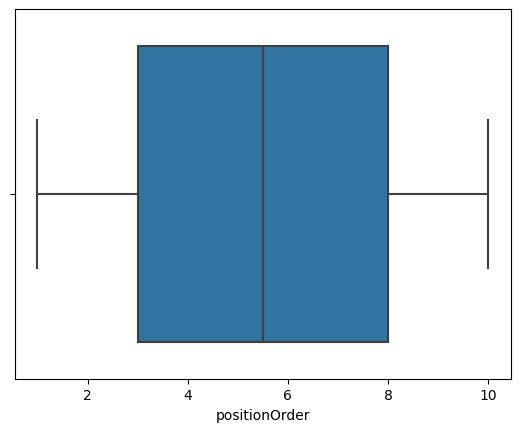

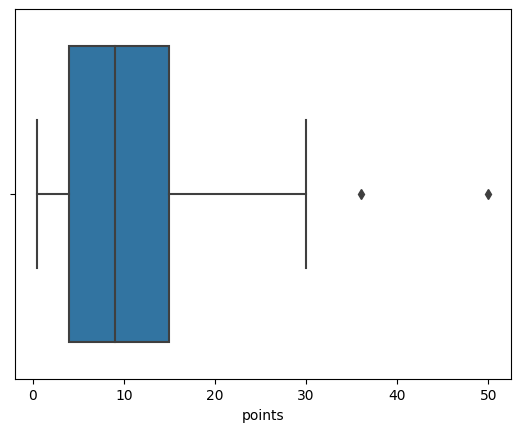

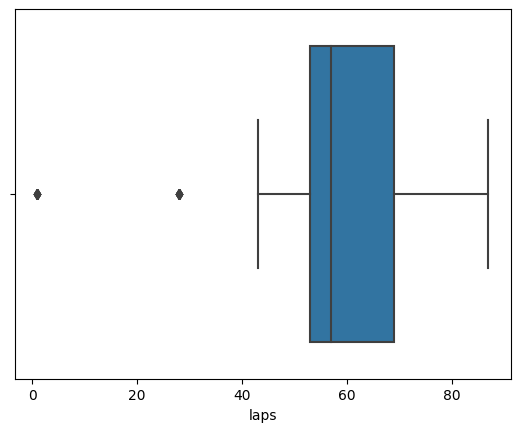

In [ ]:
df= results
cols_to_check = ['grid', 'positionOrder', 'points', 'laps']
for col in df:
  if col in cols_to_check:
    plt.figure()
    sns.boxplot(x=col, data=df)
    q75,q25 = np.percentile(df[col],[75,25])

    intr_qr = q75-q25
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)

    print(col, max,min )

    l = []
    c = 0
    for x in df[col]:
      if x >= max:
        c += 1
        l.append(np.percentile(df[col], 99))
      elif x <= min:
        c += 1
        l.append(np.percentile(df[col], 1))
      else:
        l.append(x)
    print(c)
    df[col] = l


## Skewness after Quantile flooring

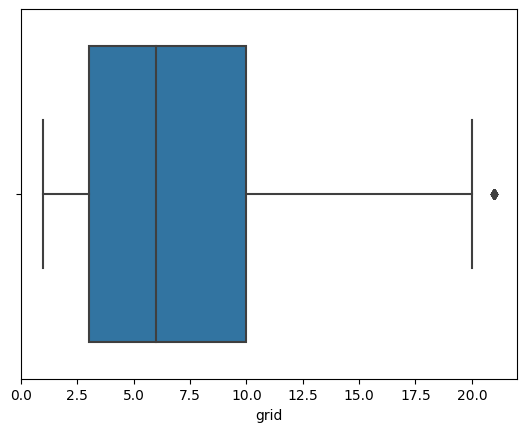

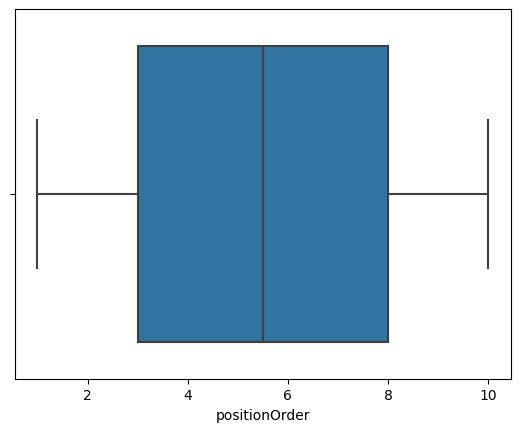

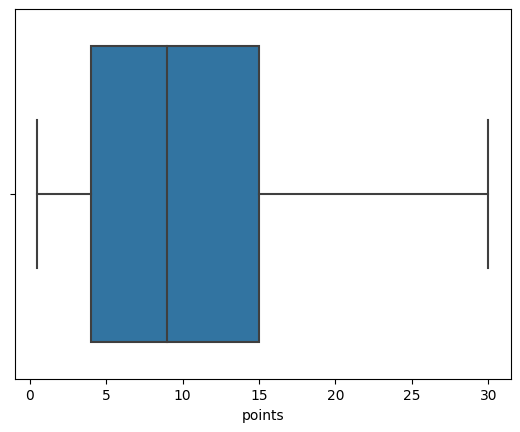

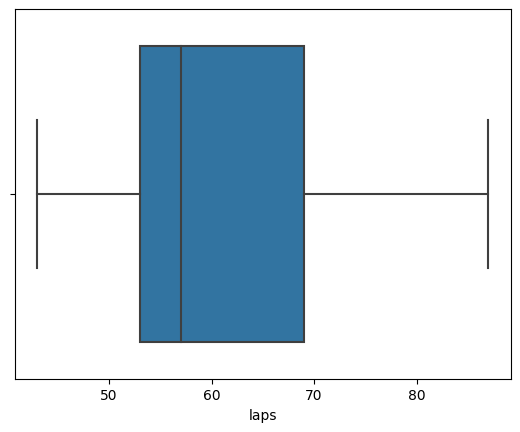

In [ ]:
df= results
cols_to_check = ['grid', 'positionOrder', 'points', 'laps']

for col in df:
  if col in cols_to_check:
    plt.figure()
    sns.boxplot(x=col, data=df)

grid  with skewness of 0.7321705506443735
positionOrder  with skewness of 0.0
points  with skewness of 0.6331545081800826
laps  with skewness of 0.3504003984793293


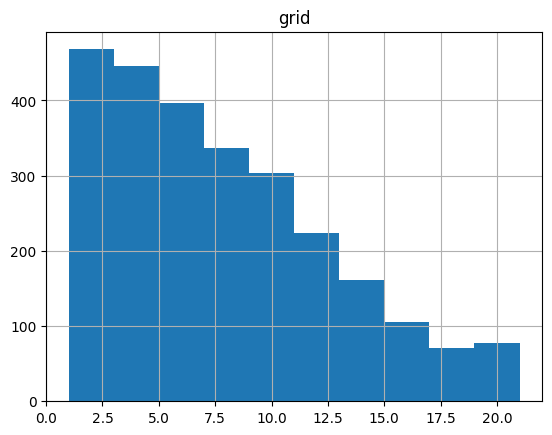

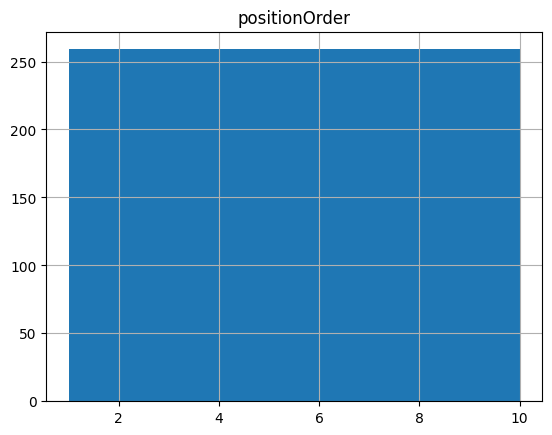

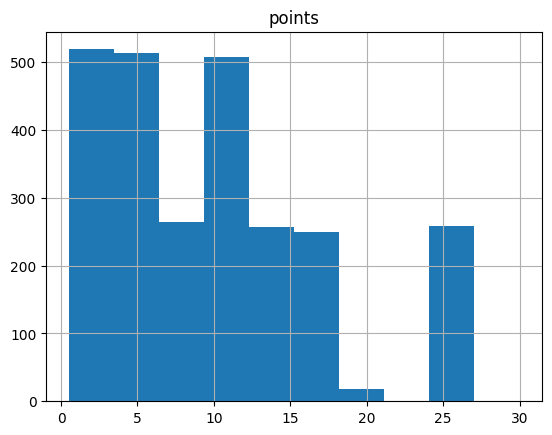

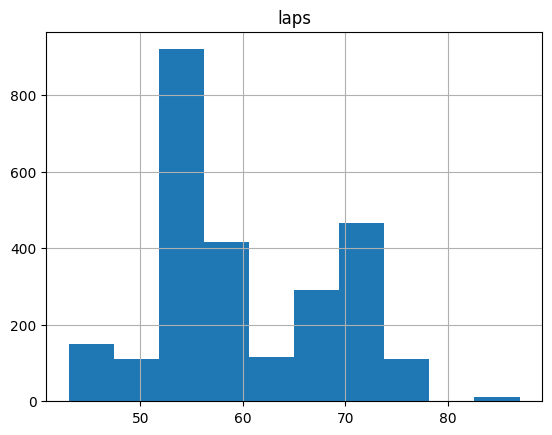

In [ ]:
df= results
cols_to_check = ['grid', 'positionOrder', 'points', 'laps']

for col in df:
  if col in cols_to_check:
    print(col,' with skewness of',df[col].skew())

df.hist(column = 'grid')
plt.show()
df.hist(column = 'positionOrder')
plt.show()
df.hist(column = 'points')
plt.show()
df.hist(column = 'laps')
plt.show()




## Using Boxcox transformation on columns with skewness > 0.5 or skewness < -0.5

In [ ]:
df= results
cols_to_check = ['grid', 'positionOrder', 'points', 'laps']

for col in df:
  if col in cols_to_check:
    if df[col].skew() > 0.5 or df[col].skew() < -0.5:
        df[col],lmbda = boxcox(df[col],lmbda=None )

for col in df:
  if col in cols_to_check:
    print(col,' with skewness of',df[col].skew())


grid  with skewness of -0.08877480384522919
positionOrder  with skewness of 0.0
points  with skewness of -0.13533969917008845
laps  with skewness of 0.3504003984793293


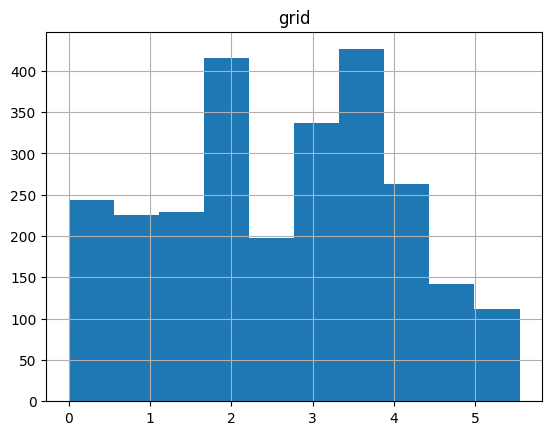

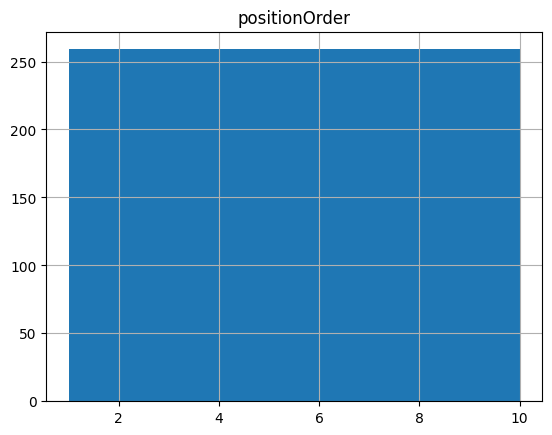

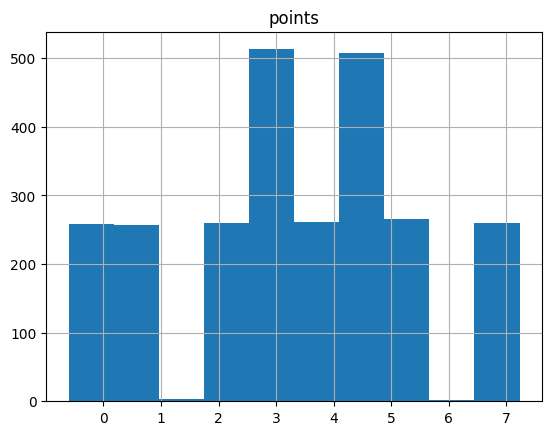

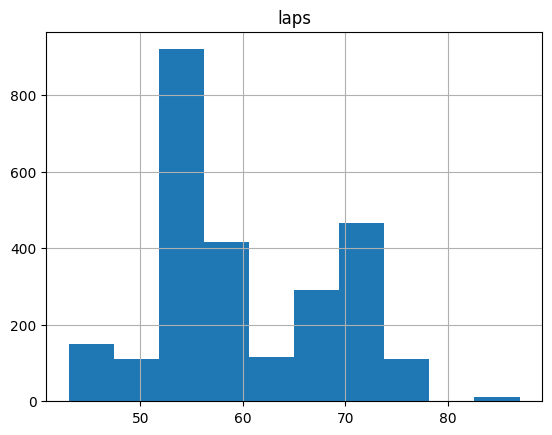

In [ ]:
df.hist(column = 'grid')
plt.show()
df.hist(column = 'positionOrder')
plt.show()
df.hist(column = 'points')
plt.show()
df.hist(column = 'laps')
plt.show()


In [ ]:
print(len(results))
results  = df
print(len(results))


2590
2590


In [ ]:
circuits = pd.read_csv('circuits.csv')
drivers =  pd.read_csv('drivers.csv')
driver_standings =  pd.read_csv('driver_standings.csv')
results = pd.read_csv('results.csv')
status = pd.read_csv('status.csv')
races = pd.read_csv('races.csv')


In [ ]:
df_q1_1 = circuits.merge(races,how='left',left_on = 'circuitId',right_on = 'circuitId')
df_q1_2 = df_q1_1.merge(results,how='left',on='raceId')
df_q1_3 = df_q1_2.merge(status,how='inner',left_on = 'statusId',right_on= 'statusId')
df_q1_4 = df_q1_3[df_q1_3['year'] >= 2000]
df_q1_4 = df_q1_4[df_q1_4['status'].isin(['Transmission','Engine','Overheating','Cooling system','Engine fire','Fuel pressure','Water pressure'])]

In [ ]:
#set(status['status'])

In [ ]:
df_q1_4 = df_q1_4.replace('\\N', '0')

In [ ]:
df_q1_4['alt'] = df_q1_4['alt'].astype(int)
df_q1_4 = df_q1_4.reset_index(drop=True)

In [ ]:
DNF = []
Factor = []
Temp = []
Alt = []

hot_countries = ['Bahrain','UAE', 'Saudi Arabia', 'Qatar']
med_countries = ['Australia',  'Mexico', 'Monaco', 'Brazil']

for stat in df_q1_4['status']:
  if stat in ['Transmission','Engine','Overheating','Cooling system','Engine fire','Fuel pressure','Water pressure']:
    DNF.append(1)
  else:
    DNF.append(0)

for i in range(len(df_q1_4)):
  if df_q1_4['country'][i] in hot_countries:
      Temp.append(2)
  elif df_q1_4['country'][i] in med_countries:
      Temp.append(1)
  else:
      Temp.append(0)

for i in range(len(df_q1_4)):
  if int(df_q1_4['alt'][i]) < 50:
      Alt.append(0)
  elif int(df_q1_4['alt'][i]) > 50 and int(df_q1_4['alt'][i]) < 200:
      Alt.append(1)
  elif int(df_q1_4['alt'][i]) > 200:
      Alt.append(2)


df_q1_4['DNF'] = DNF
df_q1_4['Temp'] = Temp
df_q1_4['Alt'] = Alt



In [ ]:
df_q1 = df_q1_4.groupby(['Alt', 'Temp'])['DNF'].sum().sort_values(ascending = False).reset_index()
df_q1

,Alt,Temp,DNF
0,2,0,121
1,0,0,89
2,1,0,77
3,0,1,42
4,2,1,23
5,0,2,22


In [ ]:
model = ols('DNF ~ C(Alt) + C(Temp) + C(Alt):C(Temp)', data=df_q1_4).fit()
sm.stats.anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
C(Alt),2.0,1.109013e-29,5.545065e-30,17.419175,5.914659e-08
C(Temp),2.0,6.933348e-33,3.466674e-33,0.010890,9.891693e-01
C(Alt):C(Temp),4.0,2.582111e-29,6.455278e-30,20.278502,4.138251e-15
Residual,368.0,1.171458e-28,3.183311e-31,NaN,NaN


In [ ]:
df_q2_1 = results.merge(drivers,left_on = 'driverId',right_on='driverId',how = 'left')
df_q2_1['full_name'] = df_q2_1['forename'] + ' ' + df_q2_1['surname']
df_q2_1 = df_q2_1[['full_name','grid','position']]


In [ ]:
df_q2_1 = df_q2_1[df_q2_1['position'] != '\\N']

In [ ]:
df_q2_1['position'] = df_q2_1['position'].astype(int)
df_q2_1['grid'] = df_q2_1['grid'].astype(int)

df_q2_1 = df_q2_1.reset_index(drop=True)

In [ ]:
df_q2_1.head(10)

,full_name,grid,position
0,Lewis Hamilton,1,1
1,Nick Heidfeld,5,2
2,Nico Rosberg,7,3
3,Fernando Alonso,11,4
4,Heikki Kovalainen,3,5
5,Kazuki Nakajima,13,6
6,Sébastien Bourdais,17,7
7,Kimi Räikkönen,15,8
8,Kimi Räikkönen,2,1
9,Robert Kubica,4,2


In [ ]:
grid = []
position = []
podium = []

for g in df_q2_1['grid']:
  if g == 1:
    grid.append(1)
  else:
    grid.append(0)

for g in df_q2_1['position']:
  if g < 4:
    podium.append(1)
  else:
    podium.append(0)

for g in df_q2_1['position']:
  if g == 1:
    position.append(1)
  else:
    position.append(0)

df_q2_1['pole'] = grid
df_q2_1['podium'] = podium
df_q2_1['winner'] = position

In [ ]:
df_q2_2 = df_q2_1[df_q2_1['podium']!= 0]
df_q2_2 = df_q2_2.reset_index(drop=True)

In [ ]:
df_q2_2.head(10)

,full_name,grid,position,pole,podium,winner
0,Lewis Hamilton,1,1,1,1,1
1,Nick Heidfeld,5,2,0,1,0
2,Nico Rosberg,7,3,0,1,0
3,Kimi Räikkönen,2,1,0,1,1
4,Robert Kubica,4,2,0,1,0
5,Heikki Kovalainen,8,3,0,1,0
6,Felipe Massa,2,1,0,1,1
7,Kimi Räikkönen,4,2,0,1,0
8,Robert Kubica,1,3,1,1,0
9,Kimi Räikkönen,1,1,1,1,1


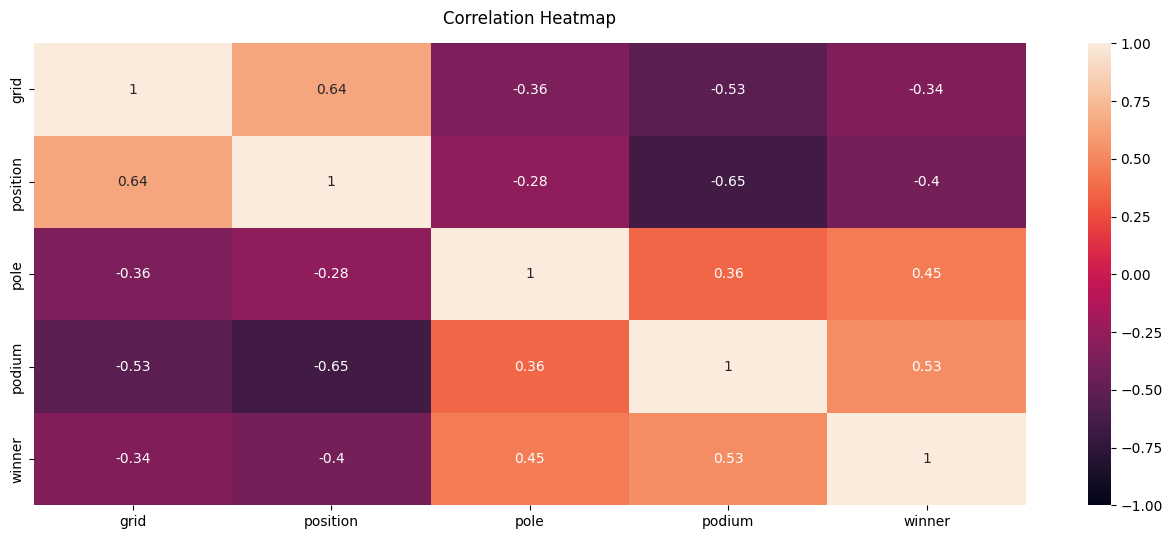

In [ ]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df_q2_1.corr(),vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=14);

In [ ]:
model = ols('podium ~ pole', data=df_q2_1).fit()
sm.stats.anova_lm(model,typ=2)

,sum_sq,df,F,PR(>F)
pole,322.820469,1.0,2172.456778,0.0
Residual,2227.022615,14987.0,NaN,NaN


In [ ]:
df_q2_1

,full_name,grid,position,pole,podium,winner
0,Lewis Hamilton,1,1,1,1,1
1,Nick Heidfeld,5,2,0,1,0
2,Nico Rosberg,7,3,0,1,0
3,Fernando Alonso,11,4,0,0,0
4,Heikki Kovalainen,3,5,0,0,0
...,...,...,...,...,...,...
14984,Valtteri Bottas,18,15,0,0,0
14985,Mick Schumacher,12,16,0,0,0
14986,Kevin Magnussen,16,17,0,0,0
14987,Lewis Hamilton,5,18,0,0,0


In [ ]:
y = df_q2_1['winner']
x = df_q2_1.iloc[:, 1:-1]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

model = LinearRegression().fit(x_train, y_train)
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)

y_pred = model.predict(x_test)
r2 = r2_score(y_test, y_pred)

y_pred_binary = np.round(y_pred)
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)

print('R-squared:', r2)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)


Coefficients: [ 0.00068077 -0.00454846  0.33622238  0.23344191]
Intercept: 0.030678639167997054
R-squared: 0.3567910234015723
Accuracy: 0.9379586390927285
Precision: 0.6716417910447762
Recall: 0.3879310344827586


In [ ]:
model = ols('winner ~ pole', data=df_q2_2).fit()
sm.stats.anova_lm(model,typ=2)

,sum_sq,df,F,PR(>F)
pole,97.291705,1.0,506.550948,2.213139e-104
Residual,625.370050,3256.0,NaN,NaN


In [ ]:
df_q3_1 = drivers.groupby('nationality')['nationality'].count().sort_values(ascending = False).reset_index(name = 'number of drivers')
fig = go.Figure(data=[go.Pie(labels=df_q3_1.nationality.head(10), values=df_q3_1['number of drivers'])])
fig.update_layout(title="Distribution of Historic Racers by Nation")
fig.update_traces(textfont_size=20, marker=dict(line=dict(color='#000001', width=2)))
fig.show()

In [ ]:
df_q3_2 = drivers.merge(driver_standings,left_on='driverId',right_on='driverId',how = 'left')
df_q3_2 = df_q3_2.merge(races,on = 'raceId',how = 'left')

In [ ]:
df_q3_3 = df_q3_2.groupby(['nationality','year','surname'])[['points','wins']].max().sort_values('points',ascending = False).reset_index()
df_q3_3.drop_duplicates(subset=['year'], inplace=True)

In [ ]:
df_q3_4 = df_q3_3.nationality.value_counts().to_frame()
fig = go.Figure(data=[go.Pie(labels=df_q3_4.index, values=df_q3_4['nationality'])])
fig.update_traces(textfont_size=20, marker=dict(line=dict(color='#000000', width=2)))
fig.update_layout(title="Distribution of Historic Champions by Nation")
fig.show()

In [ ]:
df_q3_5 = df_q3_2.groupby(['nationality','year','surname'])[['points','wins']].max().sort_values('points',ascending = False).reset_index()
df_q3_5.drop_duplicates(subset=['year'], inplace=True)

final = df_q3_5.groupby('nationality')['surname'].nunique().reset_index(name = 'champions').sort_values(by='champions',ascending = False)

ratios = final.merge(df_q3_1,on='nationality',how='inner')
ratios['perc_winners'] = (ratios.champions/ratios['number of drivers']*100).round(2)
ratios = ratios.sort_values('perc_winners',ascending = False)
ratios.head(5)

,nationality,champions,number of drivers,perc_winners
2,Finnish,3,9,33.33
6,Austrian,2,15,13.33
5,Australian,2,18,11.11
12,New Zealander,1,9,11.11
1,Brazilian,3,32,9.38


In [ ]:
df_q3_6 = ratios
fig = px.bar(df_q3_6, x='nationality', y='perc_winners',hover_data=['champions','number of drivers'], color='number of drivers',height=400)
fig.update_traces(textfont_size=20,marker=dict(line=dict(color='#000000', width=2)))
fig.update_layout(title="Champions from a nation with respect to total drivers from the nation")
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)